## 📦 Setup

First, let's import the necessary libraries and check our environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from pathlib import Path
from collections import Counter

# Check PyTorch Geometric
try:
    import torch_geometric
    from torch_geometric.data import Data, DataLoader
    print(f"✅ PyTorch Geometric version: {torch_geometric.__version__}")
except ImportError:
    print("❌ PyTorch Geometric not found. Install with: pip install torch-geometric")

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ NumPy version: {np.__version__}")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

/home/khadidja/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ PyTorch Geometric version: 2.6.1
✅ PyTorch version: 2.4.1+cu121
✅ NumPy version: 1.26.4


/home/khadidja/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📂 Load the Challenge Data

First, run the data preparation script if you haven't already:
```bash
python scripts/prepare_data.py
```

In [2]:
# Load the challenge splits
data_dir = Path('../data/challenge')

if not data_dir.exists():
    print("❌ Challenge data not found!")
    print("Please run: python scripts/prepare_data.py")
else:
    train_data = torch.load(data_dir / 'train.pt')
    val_data = torch.load(data_dir / 'val.pt')
    test_data = torch.load(data_dir / 'test.pt')
    
    with open(data_dir / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    
    print(f"📊 Dataset loaded!")
    print(f"   Train: {len(train_data)} graphs")
    print(f"   Val:   {len(val_data)} graphs")
    print(f"   Test:  {len(test_data)} graphs")

📊 Dataset loaded!
   Train: 240 graphs
   Val:   180 graphs
   Test:  180 graphs


/tmp/ipykernel_17193/2916096964.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(data_dir / 'train.pt')
/tmp/ipykernel_17193/2916096964.py:9: Futu

## 🔍 Explore the Data Structure

Let's look at what a single graph looks like.

In [3]:
# Examine a single graph
sample_graph = train_data[0]

print("📊 Sample Graph Structure:")
print(f"   - Node features (x): shape {sample_graph.x.shape}")
print(f"   - Edge index: shape {sample_graph.edge_index.shape}")
print(f"   - Number of nodes: {sample_graph.num_nodes}")
print(f"   - Number of edges: {sample_graph.edge_index.shape[1]}")
print(f"   - Label (y): {sample_graph.y.item()}")

print("\n📐 Feature statistics (first 5 features):")
print(sample_graph.x[:5, :5])

📊 Sample Graph Structure:
   - Node features (x): shape torch.Size([34, 18])
   - Edge index: shape torch.Size([2, 144])
   - Number of nodes: 34
   - Number of edges: 144
   - Label (y): 5

📐 Feature statistics (first 5 features):
tensor([[ 3.0000,  5.4619,  5.5500, -1.7200,  0.2420],
        [19.0000, 26.9101, 71.2100,  2.2200,  3.2620],
        [ 3.0000,  5.2147, 10.2700, -0.6600,  0.4570],
        [ 3.0000,  5.4116, 11.0800,  2.0400,  0.5490],
        [ 4.0000,  4.6580, 20.9300,  3.0100,  1.0170]])


## 📈 Dataset Statistics

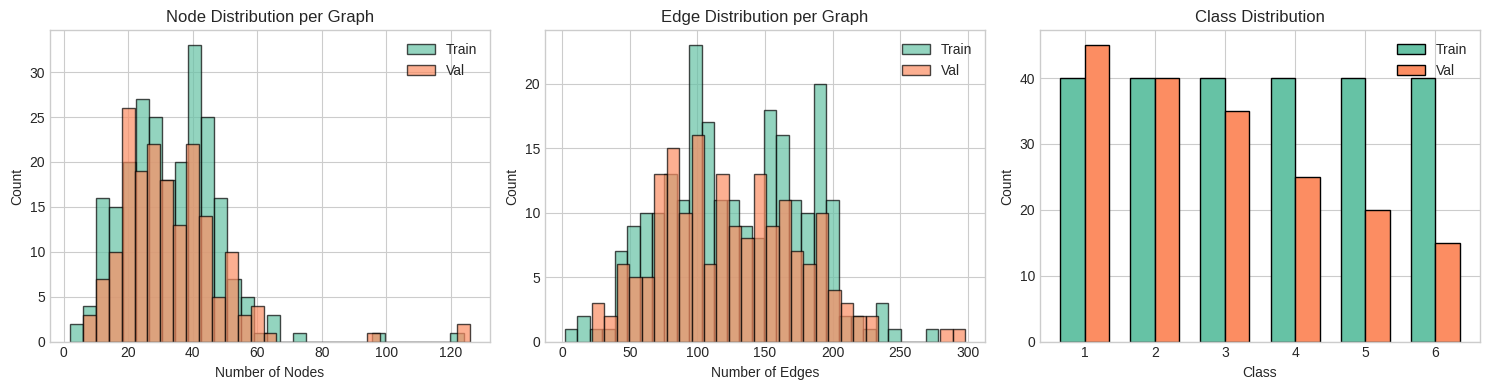


📊 Class names from metadata:
   Class 1: Oxidoreductases
   Class 2: Transferases
   Class 3: Hydrolases
   Class 4: Lyases
   Class 5: Isomerases
   Class 6: Ligases


In [4]:
# Collect statistics
def get_stats(data_list):
    num_nodes = [d.num_nodes for d in data_list]
    num_edges = [d.edge_index.shape[1] for d in data_list]
    labels = [d.y.item() for d in data_list if hasattr(d, 'y') and d.y is not None]
    
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'labels': labels
    }

train_stats = get_stats(train_data)
val_stats = get_stats(val_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Node distribution
axes[0].hist(train_stats['num_nodes'], bins=30, alpha=0.7, label='Train', edgecolor='black')
axes[0].hist(val_stats['num_nodes'], bins=30, alpha=0.7, label='Val', edgecolor='black')
axes[0].set_xlabel('Number of Nodes')
axes[0].set_ylabel('Count')
axes[0].set_title('Node Distribution per Graph')
axes[0].legend()

# Edge distribution
axes[1].hist(train_stats['num_edges'], bins=30, alpha=0.7, label='Train', edgecolor='black')
axes[1].hist(val_stats['num_edges'], bins=30, alpha=0.7, label='Val', edgecolor='black')
axes[1].set_xlabel('Number of Edges')
axes[1].set_ylabel('Count')
axes[1].set_title('Edge Distribution per Graph')
axes[1].legend()

# Class distribution
train_counts = Counter(train_stats['labels'])
val_counts = Counter(val_stats['labels'])

classes = sorted(train_counts.keys())
x = np.arange(len(classes))
width = 0.35

axes[2].bar(x - width/2, [train_counts[c] for c in classes], width, label='Train', edgecolor='black')
axes[2].bar(x + width/2, [val_counts[c] for c in classes], width, label='Val', edgecolor='black')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')
axes[2].set_title('Class Distribution')
axes[2].set_xticks(x)
axes[2].set_xticklabels(classes)
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n📊 Class names from metadata:")
for k, v in metadata['class_names'].items():
    print(f"   Class {k}: {v}")

## ❓ Challenge: Missing Features

The validation and test sets have missing features (NaN values). Let's examine this.

In [5]:
# Check for missing values
def count_missing(data_list):
    total = 0
    missing = 0
    for d in data_list:
        x = d.x.numpy()
        total += x.size
        missing += np.isnan(x).sum()
    return missing, total

train_missing, train_total = count_missing(train_data)
val_missing, val_total = count_missing(val_data)
test_missing, test_total = count_missing(test_data)

print("❓ Missing Feature Analysis:")
print(f"   Train: {train_missing:,} / {train_total:,} ({100*train_missing/train_total:.2f}%)")
print(f"   Val:   {val_missing:,} / {val_total:,} ({100*val_missing/val_total:.2f}%)")
print(f"   Test:  {test_missing:,} / {test_total:,} ({100*test_missing/test_total:.2f}%)")

❓ Missing Feature Analysis:
   Train: 0 / 144,828 (0.00%)
   Val:   12,610 / 105,750 (11.92%)
   Test:  12,143 / 101,862 (11.92%)


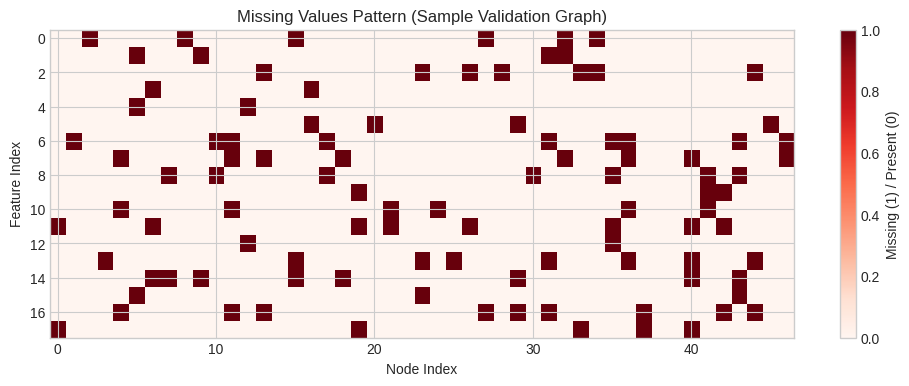

In [6]:
# Visualize missing pattern in validation set
sample_val = val_data[0]
x = sample_val.x.numpy()

plt.figure(figsize=(12, 4))
plt.imshow(np.isnan(x).T, aspect='auto', cmap='Reds')
plt.colorbar(label='Missing (1) / Present (0)')
plt.xlabel('Node Index')
plt.ylabel('Feature Index')
plt.title('Missing Values Pattern (Sample Validation Graph)')
plt.show()

## 🔧 Handling Missing Features

Here are some strategies to handle missing values:

In [7]:
def mean_imputation(data_list):
    """Simple mean imputation."""
    # Compute feature means from non-missing values
    all_features = []
    for d in data_list:
        x = d.x.numpy()
        valid = x[~np.isnan(x)]
        all_features.extend(valid)
    global_mean = np.mean(all_features)
    
    n_features = data_list[0].x.shape[1]
    feature_means = np.full(n_features, global_mean)
    
    for j in range(n_features):
        values = []
        for d in data_list:
            col = d.x[:, j].numpy()
            values.extend(col[~np.isnan(col)])
        if values:
            feature_means[j] = np.mean(values)
    
    # Apply imputation
    imputed = []
    for d in data_list:
        x = d.x.numpy().copy()
        for j in range(n_features):
            mask = np.isnan(x[:, j])
            x[mask, j] = feature_means[j]
        
        new_d = Data(
            x=torch.tensor(x, dtype=torch.float32),
            edge_index=d.edge_index,
            num_nodes=d.num_nodes
        )
        if hasattr(d, 'y') and d.y is not None:
            new_d.y = d.y
        if hasattr(d, 'graph_id'):
            new_d.graph_id = d.graph_id
        imputed.append(new_d)
    
    return imputed

# Test imputation
val_imputed = mean_imputation(val_data)
missing_after, total_after = count_missing(val_imputed)
print(f"After imputation: {missing_after} missing values (should be 0)")

After imputation: 0 missing values (should be 0)


## 🏗️ Build a Simple Model

Let's build a simple GNN model that stays under 100K parameters.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class SimpleGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, num_classes=6, num_layers=2, dropout=0.5):
        super().__init__()
        
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        # First layer
        self.convs.append(GCNConv(in_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.dropout = dropout
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = global_mean_pool(x, batch)
        x = self.classifier(x)
        
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Create model
in_dim = train_data[0].x.shape[1]
model = SimpleGCN(in_dim=in_dim, hidden_dim=64, num_layers=3)

num_params = model.count_parameters()
print(f"🏗️ Model Parameters: {num_params:,}")
print(f"   Limit: 100,000")
print(f"   Status: {'✅ Within limit' if num_params <= 100000 else '❌ Exceeds limit'}")

🏗️ Model Parameters: 12,198
   Limit: 100,000
   Status: ✅ Within limit


## 🏋️ Train the Model

In [9]:
from sklearn.metrics import f1_score, accuracy_score
import time

# Preprocess data
train_imputed = mean_imputation(train_data)
val_imputed = mean_imputation(val_data)

# Create data loaders
train_loader = DataLoader(train_imputed, batch_size=32, shuffle=True)
val_loader = DataLoader(val_imputed, batch_size=32, shuffle=False)

# Training setup
device = torch.device('cpu')
model = SimpleGCN(in_dim=in_dim, hidden_dim=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 50
history = {'train_loss': [], 'val_f1': [], 'val_acc': []}

print("🏋️ Training...")
start_time = time.time()

for epoch in range(1, epochs + 1):
    # Train
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.squeeze() - 1)  # 0-indexed
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    
    train_loss = total_loss / len(train_loader.dataset)
    
    # Validate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1) + 1
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.squeeze().cpu().numpy())
    
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_acc = accuracy_score(all_labels, all_preds)
    
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    history['val_acc'].append(val_acc)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time
print(f"\n⏱️ Training time: {training_time:.1f}s")
print(f"   Limit: 300s")
print(f"   Status: {'✅ Within limit' if training_time <= 300 else '❌ Exceeds limit'}")

/home/khadidja/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


🏋️ Training...
Epoch  10 | Loss: 1.7236 | Val F1: 0.2057 | Val Acc: 0.2778
Epoch  20 | Loss: 1.6071 | Val F1: 0.3216 | Val Acc: 0.3444
Epoch  30 | Loss: 1.5883 | Val F1: 0.1996 | Val Acc: 0.2778
Epoch  40 | Loss: 1.5325 | Val F1: 0.3517 | Val Acc: 0.3556
Epoch  50 | Loss: 1.5017 | Val F1: 0.3441 | Val Acc: 0.4000

⏱️ Training time: 4.1s
   Limit: 300s
   Status: ✅ Within limit


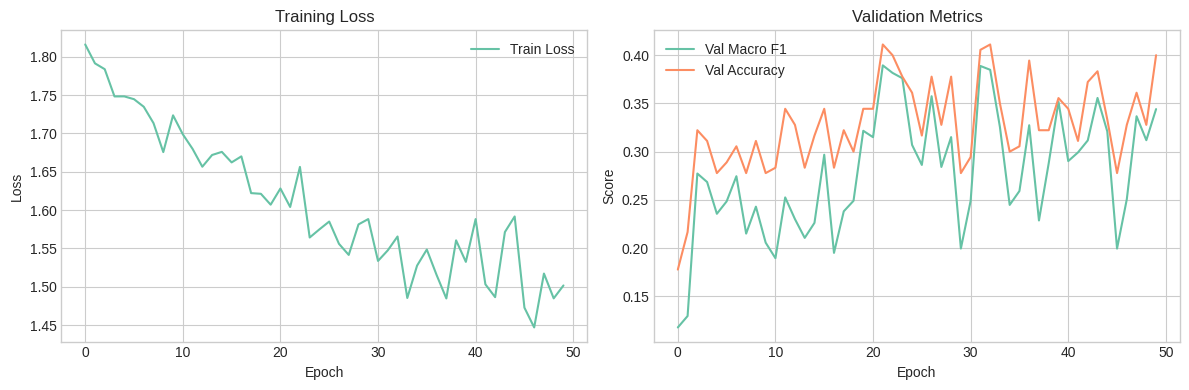


📊 Best Validation Macro F1: 0.3895


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

axes[1].plot(history['val_f1'], label='Val Macro F1')
axes[1].plot(history['val_acc'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Best Validation Macro F1: {max(history['val_f1']):.4f}")

## 🔮 Generate Predictions

In [11]:
# Preprocess test data
test_imputed = mean_imputation(test_data)
test_loader = DataLoader(test_imputed, batch_size=32, shuffle=False)

# Generate predictions
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1) + 1  # 1-indexed
        
        for i, p in enumerate(pred):
            graph_id = data.to_data_list()[i].graph_id
            predictions.append((graph_id, p.item()))

# Sort by graph_id and display first 10
predictions.sort()
print("🔮 First 10 predictions:")
for gid, pred in predictions[:10]:
    print(f"   Graph {gid}: Class {pred}")

/home/khadidja/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


🔮 First 10 predictions:
   Graph tensor([0]): Class 1
   Graph tensor([1]): Class 3
   Graph tensor([2]): Class 3
   Graph tensor([3]): Class 4
   Graph tensor([4]): Class 3
   Graph tensor([5]): Class 4
   Graph tensor([6]): Class 4
   Graph tensor([7]): Class 6
   Graph tensor([8]): Class 3
   Graph tensor([9]): Class 3


## 💾 Save Submission

In [12]:
# Save predictions
output_dir = Path('../submissions/notebook_submission')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'predictions.csv'
with open(output_file, 'w') as f:
    f.write('graph_id,prediction\n')
    for gid, pred in predictions:
        f.write(f'{gid},{pred}\n')

print(f"✅ Predictions saved to: {output_file}")
print(f"\n📝 To evaluate on validation set:")
print(f"   python scripts/evaluate.py --predictions {output_file} --ground_truth val --detailed")

✅ Predictions saved to: ../submissions/notebook_submission/predictions.csv

📝 To evaluate on validation set:
   python scripts/evaluate.py --predictions ../submissions/notebook_submission/predictions.csv --ground_truth val --detailed


## 💡 Next Steps

Here are some ideas to improve your model:

### Better Missing Value Handling
- Median imputation
- Graph-based imputation (use neighbor features)
- Learned imputation with a separate model
- Masking tokens (like BERT's [MASK])

### Architecture Improvements
- Try different GNN layers (GIN, GAT, GraphSAGE)
- Add skip connections
- Different pooling strategies (sum, attention)
- Virtual nodes

### Training Strategies
- Learning rate scheduling
- Class-weighted loss
- Focal loss
- Data augmentation (node/edge dropout)

### Regularization
- Dropout (node-level, edge-level)
- Weight decay
- Early stopping

Good luck! 🚀